In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from keras.layers.embeddings import Embedding
from keras.layers import BatchNormalization, Dense, Dropout, Flatten, LSTM
from keras.preprocessing import sequence

from tqdm import tqdm
import os

In [ ]:
!ls

sample_data


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/gdrive/My Drive/Appliedai/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [ ]:
display['COUNT(*)'].sum()

393063

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
final=final[:100000]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(100000, 10)


1    85197
0    14803
Name: Score, dtype: int64

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 100000/100000 [00:40<00:00, 2462.88it/s]


In [ ]:
len(preprocessed_reviews)

100000

### Performing required preprocessing for LSTM

In [ ]:
#get vocabulary
vocab=set()
for review in preprocessed_reviews:
    for each_word in review.split(' '):
        if each_word not in vocab:
            vocab.add(each_word)
vocab=list(vocab)
print("Number of words are",len(vocab))
all_words=len(vocab)

Number of words are 59792


In [ ]:
from itertools import islice

vocab_count=dict.fromkeys(vocab,0)
for review in preprocessed_reviews:
    for word in review.split():
        vocab_count[word]+=1

counts=dict()
for key_value_pair in sorted(vocab_count,key=vocab_count.get,reverse=True):
    counts[key_value_pair]=vocab_count[key_value_pair]
    
with_index=list(islice(counts.items(),len(counts)))
with_index=[list(i) for i in with_index]

In [ ]:
index=0
for i in with_index:
    with_index[with_index.index(i)].append(with_index.index(i)+1)

In [ ]:
with_index[0]

['not', 95899, 1]

In [ ]:
words=[i[0] for i in with_index]
sorted_index=[i[2] for i in with_index]
words_and_index=dict(zip(words,sorted_index))

In [ ]:
count=0
print('top 5 words and corresponding index:')
for i,j in words_and_index.items():
    if count>5:
        break
    print(i,j)
    count+=1

top 5 words and corresponding index:
not 1
like 2
good 3
tea 4
great 5
one 6


In [ ]:
new_preprocessed_reviews=[]
for sentance in preprocessed_reviews:
    each_review=[]
    for word in sentance.split(' '):
        each_review.append(words_and_index[word])
    new_preprocessed_reviews.append(each_review)
print(len(new_preprocessed_reviews))
print()
print(preprocessed_reviews[0])
print()
print('The above review in lstm format:')
print()
print(new_preprocessed_reviews[0])

100000

witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college

The above review in lstm format:

[20974, 24, 1198, 71, 337, 3873, 3520, 17427, 1459, 3457, 482, 72, 6175, 13095, 1201, 26504, 1967, 23456, 5627, 11, 166, 1783, 1198, 18207, 42500, 1480, 1198, 1873, 2267, 337, 68, 213, 17427, 3209, 1953]


In [ ]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
def plt_accuracy(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation accuracy")
    ax.plot(x, ty, 'r', label="Train accuracy")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

### First LSTM (same as IMDB)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_preprocessed_reviews,final['Score'], test_size=0.33)

In [ ]:
from keras.preprocessing import sequence
max_review_length = 600
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)

(67000, 600)


In [ ]:
print(all_words+1)

59793


In [ ]:
print(preprocessed_reviews[5])
print(final['Score'])

charming rhyming book describes circumstances eat not chicken soup rice month month sounds like kind thing kids would make recess sing drive teachers crazy cute catchy sounds really childlike skillfully written
138706    1
138688    1
138689    1
138690    1
138691    1
         ..
248       1
247       1
246       0
245       1
244       1
Name: Score, Length: 100000, dtype: int64


In [ ]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(all_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

In [ ]:
history=model.fit(X_train, y_train, epochs=10, batch_size=64,validation_data=(X_test, y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,10+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Accuracy')
# list of epoch numbers
x = list(range(1,10+1))
vy = history.history['val_accuracy']
ty = history.history['accuracy']
plt_accuracy(x, vy, ty, ax)

### Second LSTM

In [ ]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(all_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.7))
model.add(LSTM(30))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 600, 32)           1913376   
_________________________________________________________________
lstm (LSTM)                  (None, 600, 100)          53200     
_________________________________________________________________
dropout (Dropout)            (None, 600, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                15720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 1,982,327
Trainable params: 1,982,327
Non-trainable params: 0
____________________________________________

In [ ]:
history=model.fit(X_train, y_train, epochs=10, batch_size=64,validation_data=(X_test, y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
1047/1047 [==============================] - 83s 80ms/step - loss: 0.2825 - accuracy: 0.8953 - val_loss: 0.2020 - val_accuracy: 0.9190
Epoch 2/10
1047/1047 [==============================] - 82s 78ms/step - loss: 0.1592 - accuracy: 0.9416 - val_loss: 0.1943 - val_accuracy: 0.9240
Epoch 3/10
1047/1047 [==============================] - 82s 78ms/step - loss: 0.1166 - accuracy: 0.9593 - val_loss: 0.2164 - val_accuracy: 0.9257
Epoch 4/10
1047/1047 [==============================] - 82s 78ms/step - loss: 0.0843 - accuracy: 0.9715 - val_loss: 0.2326 - val_accuracy: 0.9187
Epoch 5/10
1047/1047 [==============================] - 82s 78ms/step - loss: 0.0660 - accuracy: 0.9785 - val_loss: 0.2739 - val_accuracy: 0.9225
Epoch 6/10
1047/1047 [==============================] - 82s 78ms/step - loss: 0.0487 - accuracy: 0.9848 - val_loss: 0.3350 - val_accuracy: 0.9160
Epoch 7/10
1047/1047 [==============================] - 82s 78ms/step - loss: 0.0382 - accuracy: 0.9882 - val_loss: 0.3525 -

Test score: 0.4238350987434387
Test accuracy: 0.9110302925109863


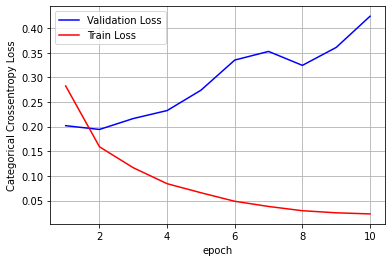

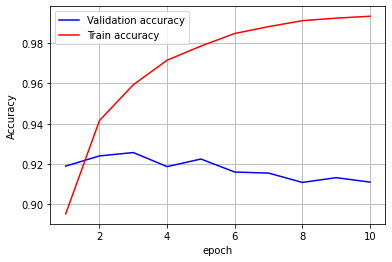

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,10+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Accuracy')
# list of epoch numbers
x = list(range(1,10+1))
vy = history.history['val_accuracy']
ty = history.history['accuracy']
plt_accuracy(x, vy, ty, ax)

## Observations:

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
print('LSTM')
x.field_names = ["# Layers","unit size","Train accuracy","Test accuracy"]
x.add_row(["1","100","99.34%","91.04%"])
x.add_row(["2(with dropout)","[100,30]","99.45%","91.41%"])
print(x)

LSTM
+-----------------+-----------+----------------+---------------+
|     # Layers    | unit size | Train accuracy | Test accuracy |
+-----------------+-----------+----------------+---------------+
|        1        |    100    |     99.34%     |     91.04%    |
| 2(with dropout) |  [100,30] |     99.45%     |     91.41%    |
+-----------------+-----------+----------------+---------------+


1.I have tried BatchNormalization as the NN is not deep it is not adding much value,so ended up not using it.<br>
2.Adding more LSTM layers or units makes the model complex and is not increasing the performance too much.<br>
3.Dropout layer is slightly helping with overfitting.

In [ ]:
model.save('review_rating.h5')

### Performing required preprocessing for LSTM

In [ ]:
preprocessed_reviews=["Between the Lovecraftian overtones and Liberato’s performance", 
"The Beach House offers up beautifully shot terror and will make you think before opening your door."]

In [ ]:
#get vocabulary
vocab=set()
for review in preprocessed_reviews:
    for each_word in review.split(' '):
        if each_word not in vocab:
            vocab.add(each_word)
vocab=list(vocab)
print("Number of words are",len(vocab))
all_words=len(vocab)

Number of words are 23


In [ ]:
from itertools import islice

vocab_count=dict.fromkeys(vocab,0)
for review in preprocessed_reviews:
    for word in review.split():
        vocab_count[word]+=1

counts=dict()
for key_value_pair in sorted(vocab_count,key=vocab_count.get,reverse=True):
    counts[key_value_pair]=vocab_count[key_value_pair]
    
with_index=list(islice(counts.items(),len(counts)))
with_index=[list(i) for i in with_index]

In [ ]:
index=0
for i in with_index:
    with_index[with_index.index(i)].append(with_index.index(i)+1)

In [ ]:
with_index[0]

['and', 2, 1]

In [ ]:
words=[i[0] for i in with_index]
sorted_index=[i[2] for i in with_index]
words_and_index=dict(zip(words,sorted_index))

In [ ]:
count=0
print('top 5 words and corresponding index:')
for i,j in words_and_index.items():
    if count>5:
        break
    print(i,j)
    count+=1

top 5 words and corresponding index:
and 1
will 2
Lovecraftian 3
make 4
up 5
door. 6


In [ ]:
new_preprocessed_reviews=[]
for sentance in preprocessed_reviews:
    each_review=[]
    for word in sentance.split(' '):
        each_review.append(words_and_index[word])
    new_preprocessed_reviews.append(each_review)
print(len(new_preprocessed_reviews))
print()
print(preprocessed_reviews[0])
print()
print('The above review in lstm format:')
print()
print(new_preprocessed_reviews[0])

2

Between the Lovecraftian overtones and Liberato’s performance

The above review in lstm format:

[15, 17, 3, 14, 1, 19, 9]


In [ ]:
from tensorflow.keras.models import load_model
model1=load_model('/content/review_rating.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
print(model1.predict(new_preprocessed_reviews[0]))
print(new_preprocessed_reviews[0])

[[0.8716632 ]
 [0.65348434]
 [0.9544068 ]
 [0.81204706]
 [0.04089606]
 [0.46869424]
 [0.55132437]]
[15, 17, 3, 14, 1, 19, 9]
